### Summary of Akshita's Setup
- **Step 1**: Map compute (N, D) to task loss (bpb on CF continuation). *Only the final checkpoints are used*
- **Step 2**: Map task loss (bpb on CF) to task score (accuracy) using sigmoid.

Additional hacks:
1. **2 additional points**: Additional points added for perfect score (bpb=0.01, accuracy=1) and random chance (bpb=2.6, accuracy=0.25). bpb=2.6 is arbitrarily chosen
2. **Moving average**: Use moving average with window size = 20. 20 is arbitrarily chosen
3. **Expontential moving average**: Use EMA with alpha=0.5
4. **Last n% of points**: Instead of all bpb, only use the last 2% of points per run. 2% is arbitrary.

Notes:
- BoolQ is removed from aggregate scores due to noise

Experimental settings:
- **Easy**: Use every model up to the target model
- **Hard**: Use models with 1/10th the training tokens of the target model

In [1]:
%load_ext autoreload
%autoreload 2

### Setup (Pull W&B Logs)

In [2]:
from olmo.scaling.scaling_laws.download_wandb_logs import main as download_wb
from a_david_noise_utils import get_name_size_length
from argparse import Namespace
import os
import itertools

WANDB_RESULTS = "wandb/peteish-moreeval"
FIGURES = "figures"

run_names = [
    f"ai2-llm/olmo-ladder/peteish-moreeval-{size}-{length}"
    for size, length in itertools.product(["190M", "370M", "600M", "760M", "1B"], ["1xC", "2xC", "5xC", "10xC"])
]

validation_outputs = {}
for run_name in run_names:
    if "peteish7" in run_name:
        output_name = "peteish7"
    else:
        output_name = run_name.split("/")[-1]
        name, size, length = get_name_size_length(run_name)
        output_name = f"{size}-{length}"
    output_path = f"{WANDB_RESULTS}/{output_name}.csv"
    args = Namespace(
        wandb_names=[run_name],
        # x_axis="throughput/total_tokens",
        x_axis="_step",
        y_axis=["eval/validation-and-bpb-and-downstream-more-eval"],
        output_path=output_path,
        eval_only=False
    )
    if not os.path.exists(output_path):
        download_wb(args)
    validation_outputs[output_name] = output_path

/Users/dhei/miniconda3/envs/olmo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Hard Setting

In [3]:
import ladder_peteish as ladder

# Find the model size corresponding to 10x less compute
all_flops = []
for size in ["190M", "370M", "600M", "760M", "1B"]:
    paths = []
    for length in ["1xC", "2xC", "5xC", "10xC"]:
        if size == "3B" and length == "10xC":
            break
        model_flops = ladder.MODEL_GFLOPS[size]
        length_in_tokens = ladder.parse_length(length, ladder.parse_size(size))
        total_flops = (model_flops * length_in_tokens) / 1e18
        all_flops.append((f"{size}-{length}", total_flops))
sorted_by_flops = sorted(all_flops, key=lambda x:x[1])
corresponding_flops_10x = {
    "1B-10xC": "1B-1xC",
}

# for tup in sorted_by_flops:
#     print(tup)
# print("Using generous upper-bounds to find nearest corresponding 10x less flops run")
# for key, val in corresponding_flops_10x.items():
#     print(f"{key} uses upto {val}")

In [4]:
from a_david_noise_utils import COLOR_MAP, N_LAST_CKPTS
from olmo.scaling.scaling_laws.utils import FinalConfig

all_configs = []

for run_name, max_train_run in corresponding_flops_10x.items():
    configs_size = {}
    for (train_run, _) in sorted_by_flops:
        
        train_size, train_length = train_run.split("-")
        if train_size in configs_size:
            configs_size[train_size]["paths"].append(f"wandb/peteish-moreeval/{train_run}.csv")
        else:
            configs_size[train_size] = {
                "paths": [f"wandb/peteish-moreeval/{train_run}.csv"],
                "mode": "train",
                "n": ladder.MODEL_PARAMS[train_size],
                "label": train_size,
                "color": COLOR_MAP[train_size]
            }

        if train_run == max_train_run:
            break

    size, length = run_name.split("-")
    configs_size[f"{size}-{length}"] = {
        "paths": [f"wandb/peteish-moreeval/{run_name}.csv"],
        "mode": "eval",
        "n": ladder.MODEL_PARAMS[size],
        "label": size,
        "color": COLOR_MAP[size]
    }
    configs_size = {name: FinalConfig(**config) for name, config in configs_size.items()}
    all_configs.append(configs_size)

#### Predicting 1B at 10xC

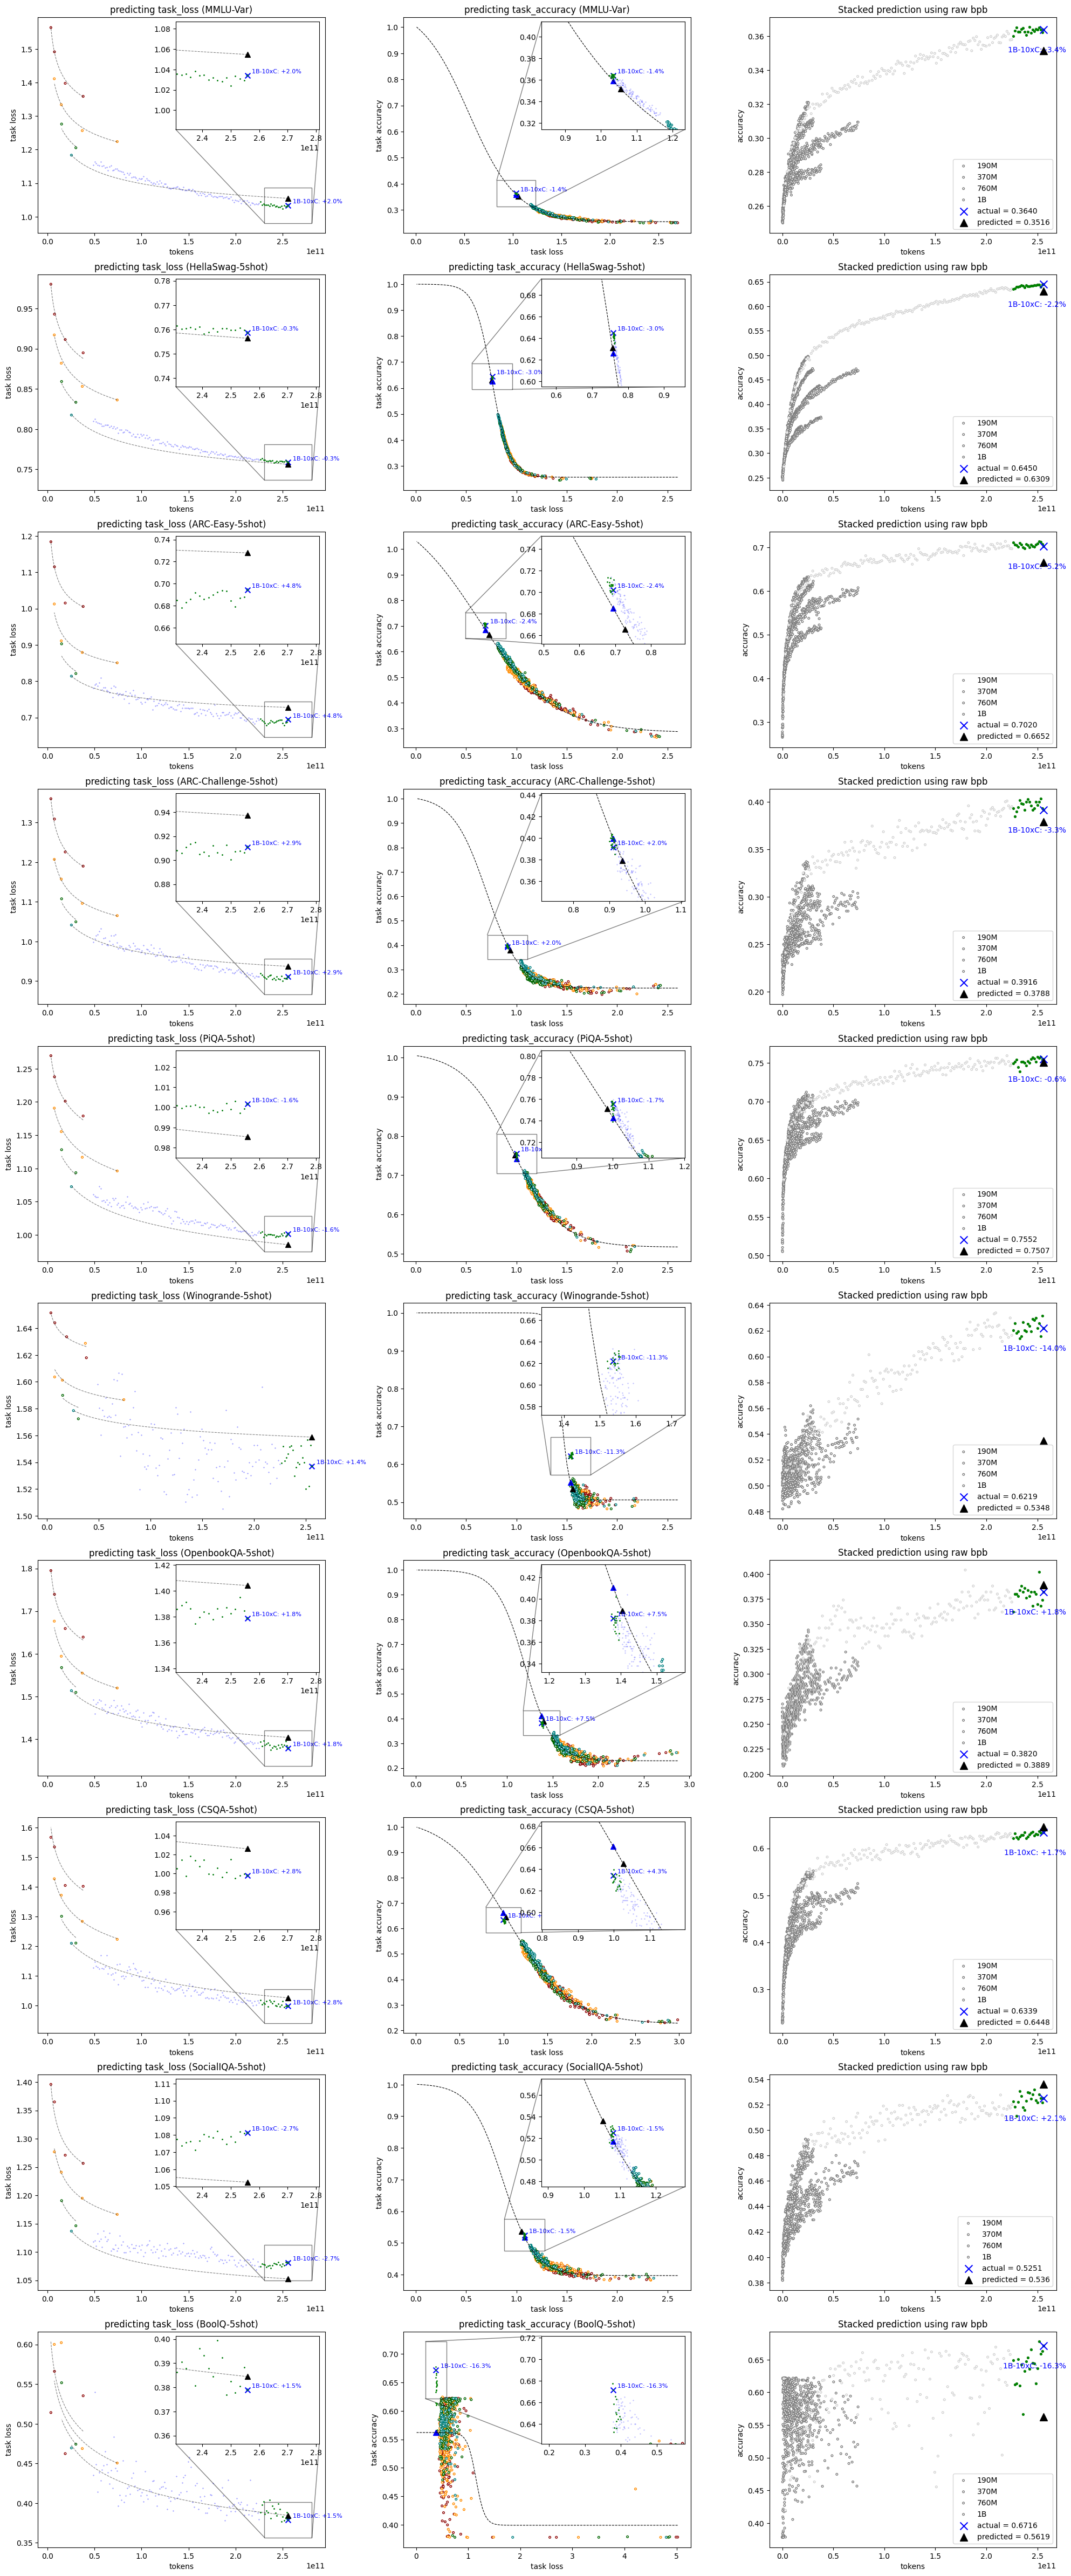

In [5]:
# from a_david_noise_utils import get_all_data_by_name, get_dataframe, plot_step1, plot_step2, fit_step1, fit_step2, get_predicted_error, get_last_n_predicted_error, plot_stacked, run_stacked
# from a_david_noise_utils import BASELINE_BY_TASK_NAME, TASKS
# import matplotlib.pyplot as plt

from a_david_noise_utils import run_stacked

step1_error, step2_error, stacked_error = run_stacked(all_configs)

### New Analysis

In [6]:
from IPython.display import display, Markdown
display(Markdown(r'$$\text{relative error} = \frac{|\text{pred}-\text{actual}|}{\text{actual}}\times100\%$$'))
display(Markdown(r'$$\text{CV} = \frac{\text{Std. Dev. (last n points)}}{\text{Mean (last n points)}}\times100\%$$'))
display(Markdown(r'$$\text{z-score} = \frac{\text{absolute error}}{\text{Std. Dev. (last n points)}}$$'))

$$\text{relative error} = \frac{|\text{pred}-\text{actual}|}{\text{actual}}\times100\%$$

$$\text{CV} = \frac{\text{Std. Dev. (last n points)}}{\text{Mean (last n points)}}\times100\%$$

$$\text{z-score} = \frac{\text{absolute error}}{\text{Std. Dev. (last n points)}}$$

In [7]:
import pandas as pd

def get_results_table(error_results):
    results = pd.DataFrame()
    model_data = error_results['1B-10xC']
    for benchmark_name, data in model_data.items():
        y_lastn_std = data['y_lastn_std']
        y_lastn_coeff_var = data['y_lastn_coeff_var']
        y_lastn_z_score = data['y_lastn_z_score']
        
        row_data = {
            ('Abs error', 'abs'): round(data['abs_error'], 3),
            ('Rel error', 'rel'): f'{(data["rel_error"]*100):.2f}%',
            ('Target (1B-10xC)', 'std'): round(y_lastn_std, 4),
            ('Target (1B-10xC)', 'CV'): f'{(y_lastn_coeff_var * 100):.2f}%',
            ('Z-score', 'z-score'): round(y_lastn_z_score, 2),
        }
        
        df_row = pd.DataFrame([row_data], index=[benchmark_name])
        results = pd.concat([results, df_row])

    results.columns = pd.MultiIndex.from_tuples(results.columns)
    return results

def make_fancy(grouped_results):
    new_columns = [
        ('Target (1B-10xC)', 'Abs Std') if col == ('Target (1B-10xC)', 'std')
        else ('Target (1B-10xC)', 'Rel Std (CV)') if col == ('Target (1B-10xC)', 'CV')
        else ('Abs error', 'Abs Error') if col == ('Abs error', 'abs')
        else ('Rel error', 'Rel Error') if col == ('Rel error', 'rel')
        else ('Z-score', 'Abs Z-score') if col == ('Z-score', 'z-score')
        else col
        for col in grouped_results.columns
    ]

    grouped_results.columns = pd.MultiIndex.from_tuples(new_columns)
    return grouped_results

grouped_results_1 = make_fancy(get_results_table(step1_error))
grouped_results_2 = make_fancy(get_results_table(stacked_error))
task_mapping = {
    'MMLU-Var': 'mmlu avg var',
    'HellaSwag-5shot': 'hellaswag 5-shot', 
    'ARC-Easy-5shot': 'arc easy 5-shot',
    'ARC-Challenge-5shot': 'arc challenge 5-shot',
    'BoolQ-5shot': 'boolq 5-shot',
    'CSQA-5shot': 'csqa 5-shot',
    'OpenbookQA-5shot': 'openbookqa 5-shot',
    'PiQA-5shot': 'piqa 5-shot',
    'SocialIQA-5shot': 'socialiqa 5-shot',
    'Winogrande-5shot': 'winogrande 5-shot'
}

target_cols = grouped_results_1.columns
step1_results   = grouped_results_1[target_cols].rename(columns={k[0]: 'Step 1' for k in grouped_results_1.columns.values})
stacked_results = grouped_results_2[target_cols].rename(columns={k[0]: 'Stacked' for k in grouped_results_2.columns.values})
step1_results         = step1_results.loc[task_mapping.keys()]
stacked_results       = stacked_results.loc[task_mapping.keys()]
step1_results.index   = step1_results.index.map(lambda x: task_mapping[x])
stacked_results.index = stacked_results.index.map(lambda x: task_mapping[x])

merged_results = pd.concat([step1_results, stacked_results], axis=1)
merged_results = merged_results.sort_values(by=('Stacked', 'Rel Std (CV)'), ascending=False)
merge_avg = merged_results.apply(
    lambda col: col.map(lambda x: abs(x) if isinstance(x, (int, float)) else float(x[:-1]))
).mean(numeric_only=True).to_frame().T
merge_avg.index = ["Unsigned Average"]
merged_results = pd.concat([merged_results, merge_avg])
display(merged_results.style.format(lambda x: f'{x:.4f}' if isinstance(x, (int, float)) else x).set_properties(**{'font-family': 'monospace'}))
# display(merged_results)

In [8]:
stacked_abs_error = merged_results[('Stacked', 'Abs Error')].iloc[:-1]  # Exclude average row
stacked_abs_std = merged_results[('Stacked', 'Abs Std')].iloc[:-1]  # Exclude average row
stacked_rel_error = merged_results[('Stacked', 'Rel Error')].iloc[:-1].map(lambda x: float(x[:-1]))  # Remove % and convert
stacked_rel_std = merged_results[('Stacked', 'Rel Std (CV)')].iloc[:-1].map(lambda x: float(x[:-1]))  # Remove % and convert

abs_correlation = stacked_abs_error.corr(stacked_abs_std)
rel_correlation = stacked_rel_error.corr(stacked_rel_std)

print(f"pearson_correlation(mean_abs_error, abs_std) = {abs_correlation:.3f}")
print(f"pearson_correlation(mean_rel_error, rel_std) = {rel_correlation:.3f}")
merged_results

merged_results.to_csv('merged_results.csv')

pearson_correlation(mean_abs_error, abs_std) = 0.719
pearson_correlation(mean_rel_error, rel_std) = 0.591


#### Takeaways
- The coefficient of variation (CV) is also known as the relative standard deviation.
- **Absolute vs. Relative Std**: Absolute and relative standard deviation give the same ordering of benchmarks for stacked error, but not step 1 error. This is because the **the target loss is higher for some metrics, underestimating the relative std. and relative error for some benchmarks.**
    - Thus, we look at absolute std. for step 1, and relative std. for stacked error, and this ordering of difficulty is consistent with the noise we observe in the above plot.
- **Excluding benchmarks**: For step 1, WinoGrande and BoolQ have an outlier absolute standard deviation.
- **Interpreting relative error across final checkpoints**: The "max/min/range" column under "Rel error" illustrates the spread of possible relative errors. 
- **Z-score**: The z-score provides a measure of error which accounts for the noise of the prediction target. This can be interpreted as the number of standard deviations away from the mean our predicted value lies.     
    - This tells us that our MMLU predictions for step 1 are particularly bad even though the relative error is low, since the standard deviation of the prediction target is also very low.
    - This also tells us that our ARC-Challenge prediction for step 2 is quite good (z-score=2.6) despite having a high relative error (rel error=8.61%), because the noise of the prediction target is particularly high.
